In [1]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast.models import MSTL

# import statsmodels.api as sm
# from sklearn.linear_model import QuantileRegressor, LinearRegression
# from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

# = = = = = =
# own stuff
# = = = = = =
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
import model_train as model_train
import model_fcast as model_fcast
import model_eval as model_eval

c:\Users\ytl_c\miniconda3\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from importlib import reload

reload(data_prepro)
reload(model_train)
reload(model_fcast)
reload(model_eval)

<module 'model_eval' from 'C:\\2023_11-PTSFC\\model_eval.py'>

### Params

In [3]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68]  # in hours

# = = = = = = = = = = = = =
# >>> generate prediction timestamps based on t0 = following thursday 00:00 dynamically
# = = = = = = = = = = = = =
custom_date = "2024-02-07"
t_now = pd.Timestamp(custom_date, tz="CET").replace(
    hour=0, minute=0, second=0, microsecond=0
)

# get thursday and wednesday
days_left = 2 - t_now.weekday()
t_wednesday = t_now + pd.Timedelta(days=days_left)
t_sunday = t_wednesday + pd.Timedelta(days=4)
print(f"wed = {t_wednesday}")
print(f"sun = {t_sunday}")

t_wednesday_next = t_wednesday + pd.Timedelta(days=7)
print(f"next wed = {t_wednesday_next}")

# get required submission horizons
# based on fcast horizons generate timestamps from t0
subm_timestamps = []
for fcast in fcast_hor:
    subm_timestamps.append((t_wednesday + pd.Timedelta(days=1, hours=fcast)))
print(subm_timestamps)

wed = 2024-02-07 00:00:00+01:00
sun = 2024-02-11 00:00:00+01:00
next wed = 2024-02-14 00:00:00+01:00
[Timestamp('2024-02-09 12:00:00+0100', tz='CET'), Timestamp('2024-02-09 16:00:00+0100', tz='CET'), Timestamp('2024-02-09 20:00:00+0100', tz='CET'), Timestamp('2024-02-10 12:00:00+0100', tz='CET'), Timestamp('2024-02-10 16:00:00+0100', tz='CET'), Timestamp('2024-02-10 20:00:00+0100', tz='CET')]


### Data Prep

In [4]:
# = = = = = = = = = = = = =
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime("%Y%m%d"))
df_energy.info()
df_energy.tail(5)

# # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# # take smaller dataset
# start   = '2018-01-01'
# end     = df_energy['timestamp_CET'].max()
# df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
#                                 (df_energy['timestamp_CET'] <= end)]

# print('- '*15)
# print(f"take smaller dataset ... from {start} to {end}")
# print(df_energy_small.info())

# # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# # feature engineering and preparing training data

# df_energy_dummy = data_prepro.create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')
# df_energy_fturs = data_prepro.create_features_df(df_energy_small, holiday_method='separate', lags=[24, 7*24])

# X_train_fturs = df_energy_fturs.drop(['gesamt', 'timestamp_CET'], axis=1)
# y_train_fturs = df_energy_fturs['gesamt']

# X_train_dummy = df_energy_dummy.drop(['gesamt', 'timestamp_CET'], axis=1)
# y_train_dummy = df_energy_dummy['gesamt']

> cwd = C:\2023_11-PTSFC
> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


> 0 NA in df
> last valid index = 2024-02-07 22:45:00+00:00
> done and saved to 2015-01-01_2024-02-07_energy.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79800 entries, 2014-12-31 23:00:00+00:00 to 2024-02-07 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79800 non-null  datetime64[ns, CET]
 1   gesamt         79800 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-02-07 18:00:00+00:00,2024-02-07 19:00:00+01:00,66516.00
2024-02-07 19:00:00+00:00,2024-02-07 20:00:00+01:00,63656.00
2024-02-07 20:00:00+00:00,2024-02-07 21:00:00+01:00,60362.75
2024-02-07 21:00:00+00:00,2024-02-07 22:00:00+01:00,57054.25
2024-02-07 22:00:00+00:00,2024-02-07 23:00:00+01:00,53301.00


### Model Train / Load

In [85]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train models

# # quantile regression with dummies
# all_models_quant_reg = model_train.fit_quant_reg(X_train_dummy, y_train_dummy, quantiles=quantiles)

# # gradient boosting with features
# all_models_grad_boost = model_train.fit_grad_boost(X_train_fturs, y_train_fturs, quantiles=quantiles)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# save trained models

# fname_time = t_wednesday.strftime('%Y_%m_%d')
# path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
# if not os.path.exists(path):
#     os.makedirs(path)

# train_start = X_train_dummy.index.min().strftime('%Y%m%d')
# train_end = X_train_dummy.index.max().strftime('%Y%m%d')

# with open(f'{path}/{train_start}_{train_end}_all_models_quant_reg.pickle', 'wb') as handle:
#     pickle.dump(all_models_quant_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(f'{path}/{train_start}_{train_end}_all_models_grad_boost.pickle', 'wb') as handle:
#     pickle.dump(all_models_grad_boost, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# read trained models

fname_time = t_wednesday.strftime("%Y_%m_%d")
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"

# path = f"C:/2023_11-PTSFC/submissions/2024_01_17"
# train_start = X_train_dummy.index.min().strftime('%Y%m%d')
# train_end = X_train_dummy.index.max().strftime('%Y%m%d')

# get all files in directory that end with .pickle
all_files = [file for file in os.listdir(path) if file.endswith(".pickle")]

quant_reg_files = [file for file in all_files if "quant_reg" in file]
grad_boost_files = [file for file in all_files if "grad_boost" in file]

print(f"quant reg files: {quant_reg_files}")
print(f"grad boost files: {grad_boost_files}")

with open(f"{path}/{quant_reg_files[-1]}", "rb") as handle:
    all_models_quant_reg = pickle.load(handle)

with open(f"{path}/{grad_boost_files[-1]}", "rb") as handle:
    all_models_grad_boost = pickle.load(handle)

quant reg files: ['20180101_20240207_all_models_quant_reg.pickle']
grad boost files: ['20180101_20240207_all_models_grad_boost.pickle']


### Iterative Ensemble Forecast from Thursday

first input dataframe from 2024-01-31 22:00:00+00:00 to 2024-02-07 22:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
2024-02-11 11:00:00+00:00 to 2024-02-11 22:00:00+00:00
= = = = = = = = = = = = = = = 
all iterative fcasts done ...


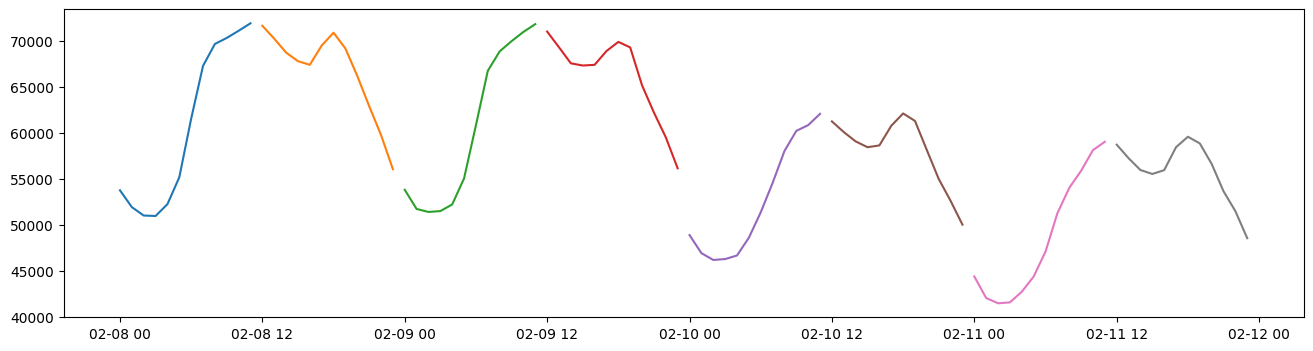

,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-02-07 23:00:00+00:00,48285.338881,52090.529241,53747.110454,55395.309990,57954.879014
2024-02-08 00:00:00+00:00,46645.056105,49921.518615,51918.090906,53473.093242,55738.729834
2024-02-08 01:00:00+00:00,45690.985892,49432.137308,51001.237304,52593.048932,54850.927085
2024-02-08 02:00:00+00:00,46076.105682,49748.293297,50949.448945,52831.542094,55479.212052
2024-02-08 03:00:00+00:00,47598.724209,51061.584526,52237.157568,53753.663026,55457.816793
...,...,...,...,...,...
2024-02-11 18:00:00+00:00,53607.593563,57192.179915,58859.716214,61425.267314,63314.907255
2024-02-11 19:00:00+00:00,50967.955413,54315.923172,56628.713715,57707.331114,60034.914856
2024-02-11 20:00:00+00:00,48168.108923,52113.826456,53645.903681,55289.240933,57832.724208
2024-02-11 21:00:00+00:00,45648.678826,50000.769905,51481.588792,53653.816405,56491.702625


In [7]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset to create future features for fcast
end = df_energy.index.max()
start = df_energy.index.max() - pd.Timedelta(days=7)
print(f"first input dataframe from {start} to {end}")

# this dataframe has values of past 7 days = last week
# because in the first step we predict the next 12 hours
# and we need the lagged values of last week for grad boost features
df_energy_small = df_energy.loc[(df_energy.index > start) & (df_energy.index <= end)]

df_fcast_iter_all = pd.DataFrame()
iterations = 8
iteration_length = 12
# fig, axes = plt.subplots(1, iterations, figsize=(iterations*8,4))
# axes = axes.flatten()
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

print("- " * 15)
print(f"> to be forecasted")

for fcast_iter in range(iterations):
    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ens_fcast_loop))
        end = df_energy_small.index.max()
        # print(f"new end timestamp: {end}")

    # add fcast index for next 12 hours
    fcast_timestamp_UTC = pd.date_range(
        start=end, periods=iteration_length + 1, freq="H"
    )[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert("CET")

    print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}", end="\r")

    # create df with timestamps of next 12 hours
    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp["timestamp_CET"] = fcast_timestamp_CET

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))

    # use data from last week for features
    # take only the last 12 rows
    df_fcast_fturs = data_prepro.create_features_df(
        df_fcast, holiday_method="separate", lags=[24, 7 * 24]
    ).tail(iteration_length)
    df_fcast_dummy = data_prepro.create_dummy_df(
        df_fcast, hour_method="seasonal", holiday_method="separate"
    ).tail(iteration_length)

    # print(df_fcast_dummy.index)
    # print(df_fcast_fturs.index)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(
            df_fcast_dummy.drop(["gesamt", "timestamp_CET"], axis=1)
        )
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(
            df_fcast_fturs.drop(["gesamt", "timestamp_CET"], axis=1)
        )
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    ens_fcast = (
        df_quant_reg_fcast["q 0.500"].values + df_grad_boost_fcast["q 0.500"].values
    ) / 2
    df_ens_fcast_loop = pd.DataFrame(index=df_quant_reg_fcast.index)
    df_ens_fcast_loop["timestamp_CET"] = df_ens_fcast_loop.index.tz_convert("CET")
    df_ens_fcast_loop["gesamt"] = ens_fcast
    df_ens_fcast_loop

    # plt.figure(figsize=(8,2))
    # ax = axes[fcast_iter]
    ax.plot(df_ens_fcast_loop["timestamp_CET"], ens_fcast)

    # save fcast to df
    df_ens_fcast_out = df_quant_reg_fcast * 0.5 + df_grad_boost_fcast * 0.5
    df_ens_fcast_out = df_ens_fcast_out.groupby(df_ens_fcast_out.index).mean()
    df_fcast_iter_all = pd.concat((df_fcast_iter_all, df_ens_fcast_out))

print("")
print("= " * 15)
print(f"all iterative fcasts done ...")

plt.show()
display(df_fcast_iter_all)

#### Fix QC & Save to df

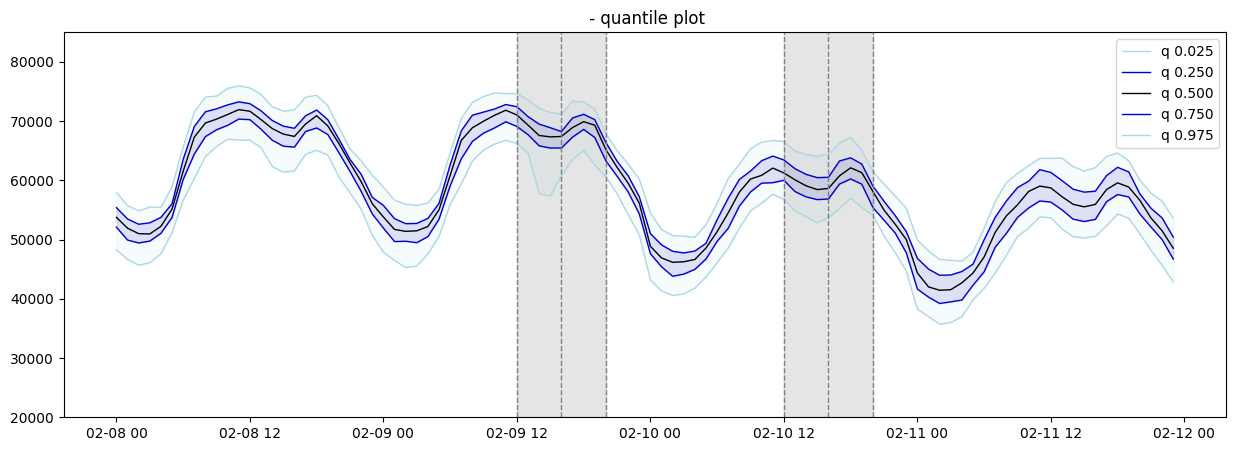

In [8]:
# - - - - - - - - - - - - -
# fix quantile crossing
df_iter_fcast_all_fixed = data_prepro.fix_quantile_crossing(df_fcast_iter_all)
# current fcast index is based on UTC only, add CET col
df_iter_fcast_all_fixed["timestamp_CET"] = df_iter_fcast_all_fixed.index.tz_convert(
    "CET"
)
# reorder cols
df_iter_fcast_all_fixed = df_iter_fcast_all_fixed[
    ["timestamp_CET", "q 0.025", "q 0.250", "q 0.500", "q 0.750", "q 0.975"]
]

# - - - - - - - - - - - - -
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_iter_fcast_all_fixed, subm_timestamps)

# - - - - - - - - - - - - -
# get fcast values for required submission horizons
mask = df_iter_fcast_all_fixed["timestamp_CET"].isin(subm_timestamps)
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_iter_fcast_all_fixed.loc[mask, :]
# display(df_submission)

# - - - - - - - - - - - - -
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:, 1:] / 1000)

df_sub = pd.DataFrame(
    {
        "forecast_date": t_wednesday.strftime("%Y-%m-%d"),
        "target": "energy",
        "horizon": [str(h) + " hour" for h in fcast_hor],
        "q0.025": submission_arr[:, 0],
        "q0.25": submission_arr[:, 1],
        "q0.5": submission_arr[:, 2],
        "q0.75": submission_arr[:, 3],
        "q0.975": submission_arr[:, 4],
    }
)

# - - - - - - - - - - - - -
# if folder with name {current wednesday} does not exists in 2023_11-PTSFC/submissions/... create it
# if folder exists ... save csv to it

# fname_time = t_wednesday.strftime('%Y_%m_%d')
# path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
# if not os.path.exists(path):
#     os.makedirs(path)

# # save entire iterative fcast to csv
# df_iter_fcast_all_fixed.to_csv(f"{path}/{fname_time}_power_iterative_fcast.csv", index=False)

# # save submission fcast to csv
# df_sub.to_csv(f"{path}/{fname_time}_power_fcast_submission.csv", index=False)
# display(df_sub)

### Direct h-step Quant Reg Fcast

In [9]:
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96 + 1, freq="H")[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert("CET")

print("- " * 15)
print(f"> to be forecasted")
print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}")

# create df with fcast timestamps
df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
df_temp["timestamp_CET"] = fcast_timestamp_CET
df_fcast_dummy = data_prepro.create_dummy_df(
    df_temp, hour_method="seasonal", holiday_method="separate"
)
# display(df_fcast_dummy)
# display(df_fcast_dummy.tail())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# fcast

print("- " * 15)
print(f"> start prediction ...")

# save fcast in df with columns = quantiles
df_quant_reg_direct_fcast = pd.DataFrame(index=df_fcast_dummy.index)

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    pred = quant_reg_model.predict(df_fcast_dummy.drop("timestamp_CET", axis=1))
    df_quant_reg_direct_fcast[name] = pred

- - - - - - - - - - - - - - - 
> to be forecasted
2024-02-07 23:00:00+00:00 to 2024-02-11 22:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


#### Fix QC and Save

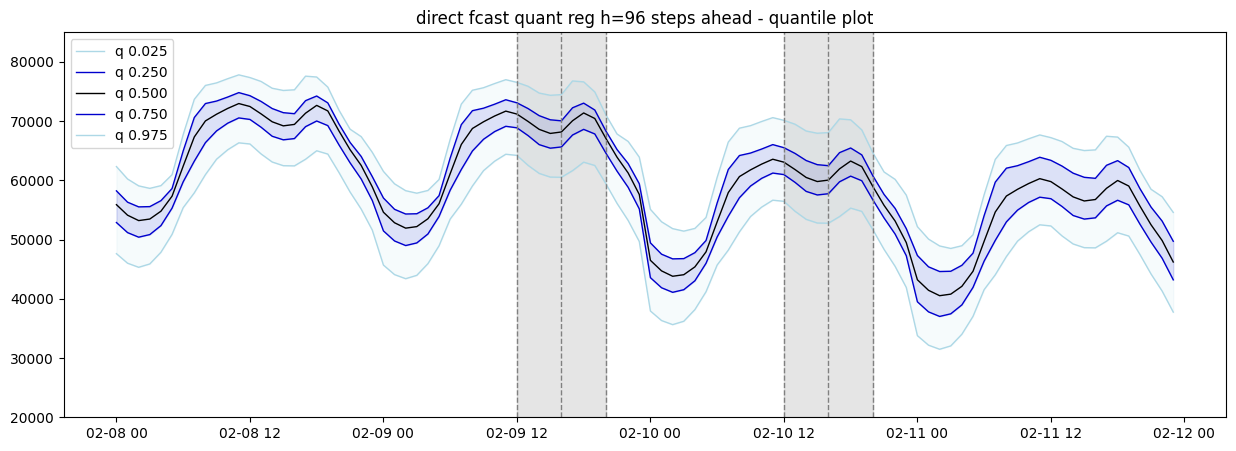

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-07,energy,36 hour,64.406667,69.1281,71.689500,73.61050,76.99575
1,2024-02-07,energy,40 hour,60.550917,65.4329,67.922583,70.22425,74.36150
2,2024-02-07,energy,44 hour,62.510917,67.8344,70.444083,71.87750,74.93000
3,2024-02-07,energy,60 hour,56.651833,61.2308,63.567250,66.03675,70.58950
4,2024-02-07,energy,64 hour,52.796083,57.5356,59.800333,62.65050,67.95525
5,2024-02-07,energy,68 hour,54.756083,59.9371,62.321833,64.30375,68.52375


In [10]:
# - - - - - - - - - - - - -
# add CET col
df_quant_reg_direct_fcast["timestamp_CET"] = df_quant_reg_direct_fcast.index.tz_convert(
    "CET"
)
# reorder cols
df_quant_reg_direct_fcast = df_quant_reg_direct_fcast[
    ["timestamp_CET", "q 0.025", "q 0.250", "q 0.500", "q 0.750", "q 0.975"]
]

# - - - - - - - - - - - - -
# plot + highlight submission horizons
model_train.plot_quantile_fcast(
    df_quant_reg_direct_fcast,
    subm_timestamps,
    title="direct fcast quant reg h=96 steps ahead",
)

# - - - - - - - - - - - - -
# get fcast values for required submission horizons
mask = df_quant_reg_direct_fcast["timestamp_CET"].isin(subm_timestamps)
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_quant_reg_direct_fcast.loc[mask, :]
# display(df_submission)

# - - - - - - - - - - - - -
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:, 1:] / 1000)

df_sub = pd.DataFrame(
    {
        "forecast_date": t_wednesday.strftime("%Y-%m-%d"),
        "target": "energy",
        "horizon": [str(h) + " hour" for h in fcast_hor],
        "q0.025": submission_arr[:, 0],
        "q0.25": submission_arr[:, 1],
        "q0.5": submission_arr[:, 2],
        "q0.75": submission_arr[:, 3],
        "q0.975": submission_arr[:, 4],
    }
)

display(df_sub)

### Naive Benchmark

In [12]:
# - - - - - - - - - - - - -
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96 + 1, freq="H")[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert("CET")

fcast_timestamps = fcast_timestamp_CET
# fcast_timestamps = subm_timestamps

# - - - - - - - - - - - - -
df_energy_benchmark = df_energy.copy()
df_energy_benchmark["month"] = df_energy_benchmark["timestamp_CET"].dt.month
df_energy_benchmark["weekday"] = df_energy_benchmark[
    "timestamp_CET"
].dt.weekday  # Monday=0, Sunday=6
df_energy_benchmark["weeknum"] = (
    df_energy_benchmark["timestamp_CET"].dt.isocalendar().week
)

last_t = 100
methods = ["linear", "median_unbiased", "normal_unbiased", "weibull"]

number_of_matches_in_past = 0
pred_baseline = np.zeros((len(methods), len(fcast_timestamps), 5))

for i, d in enumerate(fcast_timestamps):
    weekday = d.weekday()
    hour = d.hour
    weeknum = d.week

    # condition that the weekday and hour match AND the weeknum is within +/- 2 weeks of the target
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['weeknum'].between(weeknum-2, weeknum+2))

    # alternatively:
    # condition that the weekday and hour match AND the month also matches
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark.index.month == d.month)

    # alternatively:
    # condition that the weekday and hour match AND the month is within +/- 1 months of the target
    cond = (
        (df_energy_benchmark.weekday == weekday)
        & (df_energy_benchmark.index.time == d.time())
        & (df_energy_benchmark["month"].between(d.month - 1, d.month + 1))
    )

    match_df = df_energy_benchmark[cond]
    number_of_matches_in_past += match_df.shape[0]

    for m_idx, method in enumerate(methods):
        pred_baseline[m_idx, i, :] = np.quantile(
            match_df.iloc[-last_t:]["gesamt"], q=quantiles, method=method
        )

number_of_matches_in_past = number_of_matches_in_past / len(fcast_timestamps)
print(f"avg number_of_matches_in_past = {number_of_matches_in_past:.2f}")

dict_benchmark_fcast = {}

for m_idx, method in enumerate(methods):
    print("- " * 15)
    print(f"method = {method}")
    print("- " * 15)

    df_benchmark = pd.DataFrame(
        index=fcast_timestamps, columns=[f"q {q:.3f}" for q in quantiles]
    )
    df_benchmark.loc[:, :] = pred_baseline[m_idx, :, :]
    # - - - - - - - - - - - - -
    # make sure all cols are float
    df_benchmark = df_benchmark.astype(float)
    # - - - - - - - - - - - - -
    # add CET col
    df_benchmark["timestamp_CET"] = df_benchmark.index.tz_convert("CET")
    # reorder cols
    df_benchmark = df_benchmark[
        ["timestamp_CET", "q 0.025", "q 0.250", "q 0.500", "q 0.750", "q 0.975"]
    ]
    # - - - - - - - - - - - - -
    # display(df_benchmark)

    dict_benchmark_fcast[method] = df_benchmark

avg number_of_matches_in_past = 120.66
- - - - - - - - - - - - - - - 
method = linear
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = median_unbiased
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = normal_unbiased
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = weibull
- - - - - - - - - - - - - - - 


#### Plot Naive Benchmark

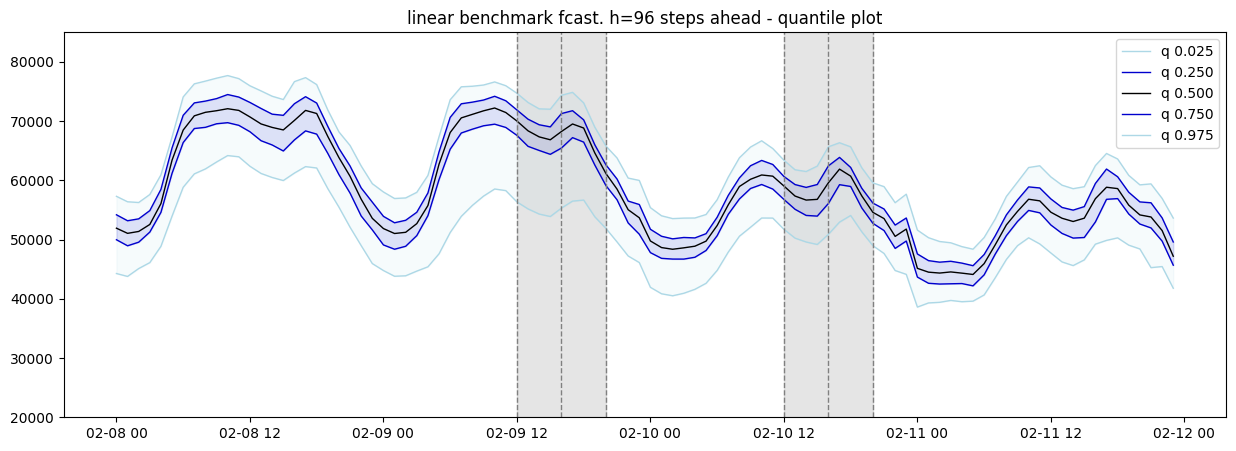

In [13]:
# for method in methods:
#     model_train.plot_quantile_fcast(dict_benchmark_fcast[method], subm_timestamps, title=f'{method} benchmark fcast. h=96 steps ahead')

method = "linear"
model_train.plot_quantile_fcast(
    dict_benchmark_fcast[method],
    subm_timestamps,
    title=f"{method} benchmark fcast. h=96 steps ahead",
)

In [93]:
# # compare the q 0.975 quantile of all benchmarks
# plt.figure(figsize=(15,5))
# for method in methods:
#     plt.plot(dict_benchmark_fcast[method]['timestamp_CET'], dict_benchmark_fcast[method]['q 0.975'], label=method)
# plt.legend()
# plt.show()

### Direct h-step Grad Boost Fcast using Naive Benchmark / Direct Quant Reg

In [94]:
# [TODO]

### Combine Ensemble = Direct QR + Direct GB + Benchmark

In [95]:
# [TODO]

### MSTL Fcast

In [14]:
mstl_train_horizon = 0.5

df_mstl_train = df_energy.iloc[-int(mstl_train_horizon * 365 * 24) :].copy()
mstl_model = MSTL(season_length=[24, 24 * 7]).fit(df_mstl_train["gesamt"])

c:\Users\ytl_c\miniconda3\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


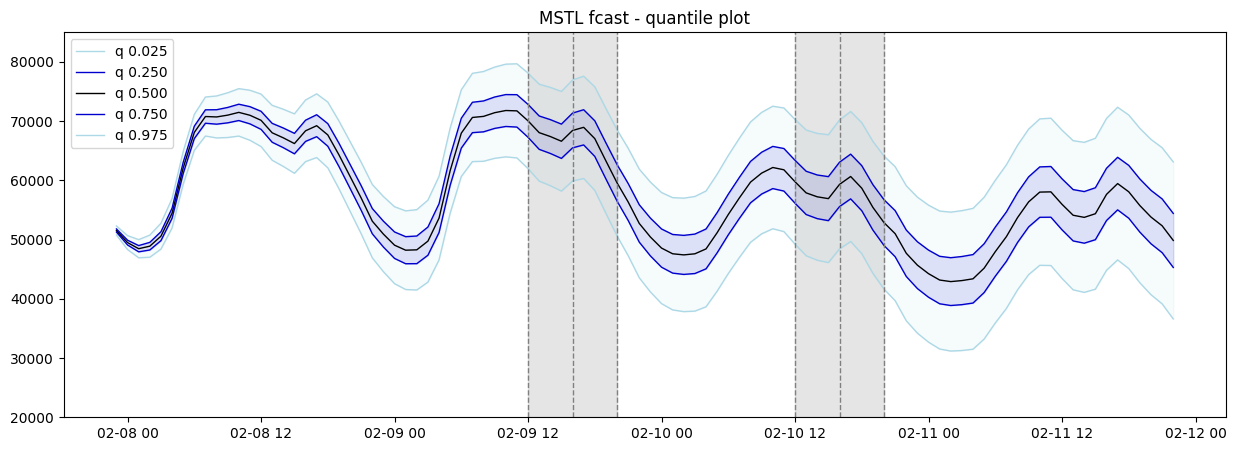

In [15]:
n_steps = 96

y_hat_dict = mstl_model.predict(h=n_steps, level=[50, 95])
y_hat_df = pd.DataFrame(y_hat_dict)
y_hat_df["timestamp_CET"] = pd.date_range(
    start=df_mstl_train["timestamp_CET"].max(), periods=len(y_hat_df), freq="H"
)

# rename columns
y_hat_df = y_hat_df.rename(
    columns={
        "mean": "q 0.500",
        "lo-50": "q 0.250",
        "hi-50": "q 0.750",
        "lo-95": "q 0.025",
        "hi-95": "q 0.975",
    }
)

y_hat_df = y_hat_df[
    ["timestamp_CET", "q 0.025", "q 0.250", "q 0.500", "q 0.750", "q 0.975"]
]
model_train.plot_quantile_fcast(y_hat_df, subm_timestamps, title="MSTL fcast")

df_mstl_fcast = y_hat_df.copy()
df_mstl_fcast.index = dict_benchmark_fcast['linear'].index

### Create Ensemble

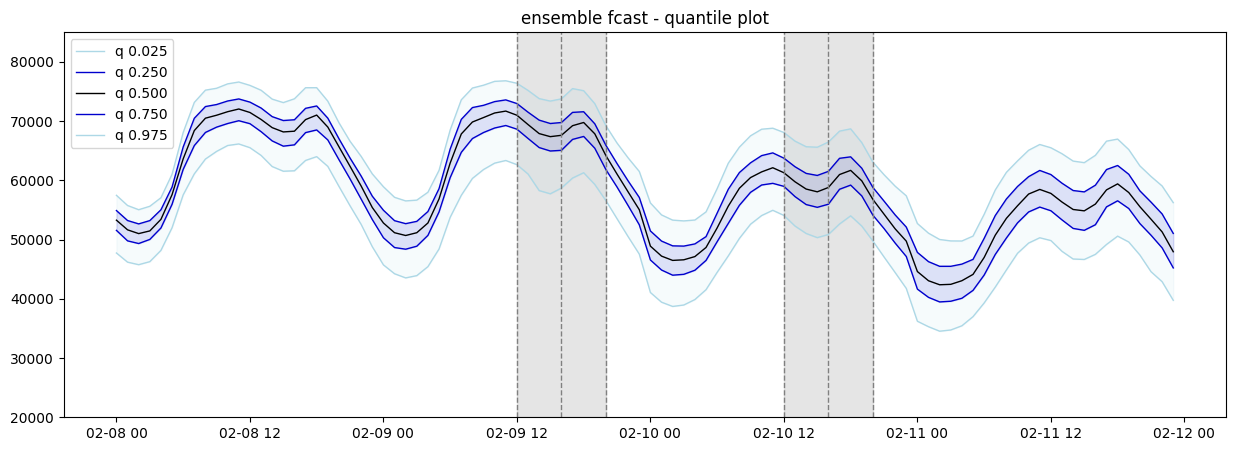

In [16]:
# average of all 3 fcasts with custom weighting
w_iter = 0.25
w_direct = 0.25
w_bench = 0.25
w_mstl = 0.25
                                             
# but ignore the first column "timestamp_CET" when calculating the average
df_ens_fcast = (df_iter_fcast_all_fixed.iloc[:,1:] * w_iter + 
                df_quant_reg_direct_fcast.iloc[:,1:] * w_direct + 
                dict_benchmark_fcast['linear'].iloc[:,1:] * w_bench + 
                df_mstl_fcast.iloc[:,1:] * w_mstl)

df_ens_fcast['timestamp_CET'] = df_iter_fcast_all_fixed['timestamp_CET']
# move timestamp col to first position
cols = df_ens_fcast.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_ens_fcast = df_ens_fcast[cols]
        
# plot
model_train.plot_quantile_fcast(df_ens_fcast, subm_timestamps, title='ensemble fcast')

In [17]:
# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_ens_fcast['timestamp_CET'].isin(subm_timestamps) 

df_submission = df_ens_fcast.loc[mask,:]
display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-02-09 11:00:00+00:00,2024-02-09 12:00:00+01:00,62645.599710,68639.972002,70993.814205,72968.400370,76389.969630
2024-02-09 15:00:00+00:00,2024-02-09 16:00:00+01:00,58698.504481,65067.635596,67606.058195,69765.233250,73759.441314
2024-02-09 19:00:00+00:00,2024-02-09 20:00:00+01:00,56572.701047,61807.001889,64171.821592,65914.478826,69216.235335
2024-02-10 11:00:00+00:00,2024-02-10 12:00:00+01:00,54077.909180,58987.243738,61287.535242,63747.578414,68078.860815
2024-02-10 15:00:00+00:00,2024-02-10 16:00:00+01:00,50859.308767,55972.579498,58797.216270,61518.273556,66466.060753
2024-02-10 19:00:00+00:00,2024-02-10 20:00:00+01:00,49752.813767,54113.948210,56777.211214,58803.933907,63069.917565


### Get Actual Data

In [18]:
""" 
now since we ran the model in retrospect on a past week 
we can compare the fcast with the actual values and compute quantile scores etc

"""

# = = = = = = = = = = = = =
# import actual data

# # get days left till sunday
# days_left = 6 - t_now.dayofweek
# # get next saturday of week in t_now
# t_sunday = t_now + pd.Timedelta(days=days_left)
# print(f"sun = {t_sunday}")

# just get next thursday
t_wednesday_next = t_wednesday + pd.Timedelta(days=7)
print(f"next thu = {t_wednesday_next}")

# = = = = = = = = = = = = =
# get data
df_energy_new = data_prepro.get_energy_data_today(
    to_date=t_wednesday_next.strftime("%Y%m%d")
)
df_energy_new.info()
df_energy_new.tail(5)

next thu = 2024-02-14 00:00:00+01:00
> cwd = C:\2023_11-PTSFC
> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


> 0 NA in df
> last valid index = 2024-02-14 13:30:00+00:00
> done and saved to 2015-01-01_2024-02-14_energy.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79959 entries, 2014-12-31 23:00:00+00:00 to 2024-02-14 13:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79959 non-null  datetime64[ns, CET]
 1   gesamt         79959 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-02-14 09:00:00+00:00,2024-02-14 10:00:00+01:00,67581.50
2024-02-14 10:00:00+00:00,2024-02-14 11:00:00+01:00,68043.50
2024-02-14 11:00:00+00:00,2024-02-14 12:00:00+01:00,67331.50
2024-02-14 12:00:00+00:00,2024-02-14 13:00:00+01:00,66162.50
2024-02-14 13:00:00+00:00,2024-02-14 14:00:00+01:00,48901.25


### Evaluation

In [19]:
# we have 4 fcasts
df_benchmark_fcast = dict_benchmark_fcast["linear"]
df_mstl_fcast = y_hat_df
df_mstl_fcast.index = df_benchmark_fcast.index

all_model_names = ["iterative", "direct", "benchmark", "mstl"]
all_models_dict = {
    "iterative": df_iter_fcast_all_fixed,
    "direct": df_quant_reg_direct_fcast,
    "benchmark": df_benchmark_fcast,
    "mstl": df_mstl_fcast,
}
# make all possible ensemble combinations between 1, 2, 3 and 4 models
import itertools

combis4 = list(itertools.combinations(all_model_names, 4))
combis3 = list(itertools.combinations(all_model_names, 3))
combis2 = list(itertools.combinations(all_model_names, 2))
combis_all = combis4 + combis3 + combis2 + [(model,) for model in all_model_names]

scores_dict = {}

for combi in combis_all:
    # take first model
    df_ens_fcast = all_models_dict[combi[0]].copy()

    # take all other models and add their q 0.500 to the first model
    for model in combi[1:]:
        df_ens_fcast.iloc[:, 1:] += all_models_dict[model].iloc[:, 1:]

    # divide by number of models
    df_ens_fcast.iloc[:, 1:] = df_ens_fcast.iloc[:, 1:] / len(combi)

    combi_name = "_".join(combi)
    scores_dict[combi_name] = model_eval.eval_fcast(df_ens_fcast, df_energy_new, subm_timestamps, quantiles).iloc[-1:]

# make dataframe from dictionary
df_res = pd.concat(scores_dict.values())
df_res.index = scores_dict.keys()

# add col of avg q scores
df_res["avg_q"] = df_res[
    [
        "q-score 0.025",
        "q-score 0.250",
        "q-score 0.500",
        "q-score 0.750",
        "q-score 0.975",
    ]
].mean(axis=1)

# rank by avg q score
df_res = df_res.sort_values(by="avg_q")
display(df_res.head(20))

,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975,avg_q
benchmark,3580.708333,0.300195,2.100547,3.580708,2.823344,0.436014,1.848162
benchmark_mstl,3838.465262,0.287653,1.558419,3.838465,3.261513,0.560373,1.901285
mstl,3137.256938,0.328083,2.226104,3.137257,3.237492,0.641809,1.914149
iterative_benchmark_mstl,4251.284826,0.189185,2.575513,4.251285,3.254003,0.526417,2.159280
iterative_benchmark,4328.816144,0.285416,3.316593,4.328816,3.031163,0.447259,2.281849
iterative_mstl,4586.573073,0.133680,2.964361,4.586573,3.469332,0.571618,2.345113
direct_benchmark_mstl,4632.782397,0.208849,2.965989,4.632782,3.536689,0.578385,2.384539
iterative_direct_benchmark_mstl,4743.817786,0.154699,3.376917,4.743818,3.462262,0.548414,2.457222
direct_benchmark,4901.062500,0.175719,3.902307,4.901063,3.455193,0.525211,2.591898
iterative_direct_benchmark,4959.682985,0.307469,4.138105,4.959683,3.383122,0.502975,2.658271
